In [2]:
!pip install psycopg2-binary  #Instala paquete de psycopg2 para coneccion con redshif
!pip install pmdarima

In [3]:
import psycopg2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
import boto3
import seaborn as sns

from time import time
from botocore.exceptions import ClientError
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from psycopg2.extras import execute_values
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [4]:
#Declaracion de variables globales
secret_name = "redshift_cluster_bi"
region_name = "ca-central-1"

#Extrae credenciales de IAM desde secret manager
session = boto3.session.Session()
client = session.client(service_name='secretsmanager',region_name=region_name)

try:
    get_secret_value_response = client.get_secret_value( SecretId=secret_name)
except ClientError as e:
    print('Exception')
    raise e

#Estrayendo valores de IAM 
secret = get_secret_value_response['SecretString']
secret_json = json.loads(secret)

# Detalles de conexión
host=secret_json['host']
user=secret_json['username']
port=secret_json['port']
password=secret_json['password']

# Establecer la conexión con base de origen
conn = psycopg2.connect(    
    database='prod_app',    
    user=user,
    password=password,
    host=host,
    port=port
)

db_params = {
    'host': host,
    'port': port,
    'database': 'dev_bi',
    'user': user,
    'password': password
}

In [5]:
query_serfinsa = '''
SELECT TRUNC(fecha) date_tx, SUM(deposito) deposits
FROM "api"."btc"."serfinsa_transaccion"
WHERE resp_des = 'APROBADA'
AND date_tx >= '2023-01-01' 
GROUP BY date_tx, resp_des
--HAVING deposits >= 100000
ORDER by date_tx ASC
'''

data = pd.read_sql_query(query_serfinsa, conn)

In [6]:
# Asegúrate de que la columna de fechas esté en formato datetime
data['date_tx'] = pd.to_datetime(data['date_tx'])

# Establece la columna de fechas como el índice del DataFrame
data.set_index('date_tx', inplace=True)

start_date = datetime(2023,8,2)
end_date = datetime(2024,4,15)
data = data[start_date:end_date]

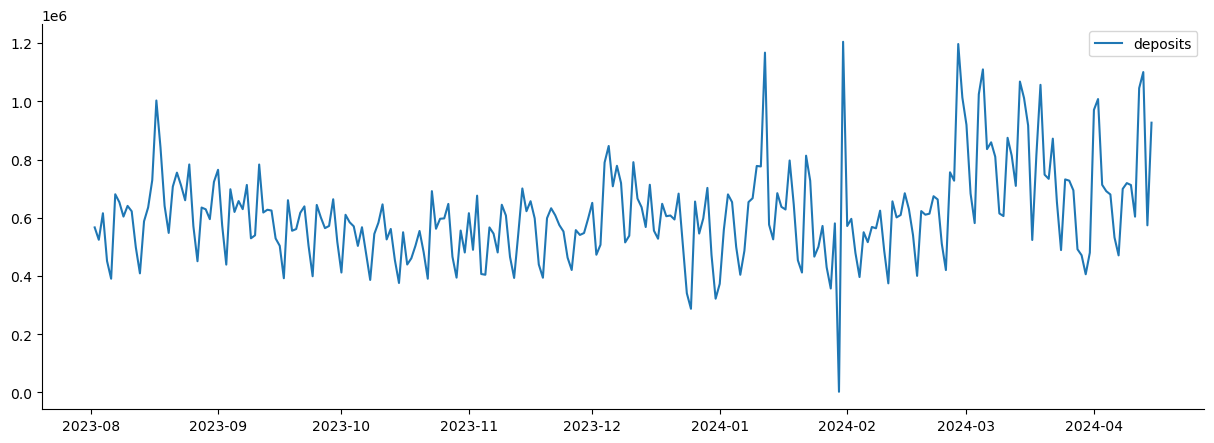

In [7]:
# Plotting the data
plt.figure(figsize=(15, 5))  # Set the figure size
plt.plot(data.index, data['deposits'], label='deposits')

# Adding legend outside the plot to the right
plt.legend(loc='upper right')


# Remove the border around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [8]:
def test_stationary(dataFrame, var):
    dataFrame['rollingMean']= dataFrame[var].rolling(5).mean()
    dataFrame['rollingStd']= dataFrame[var].rolling(5).std()

    from statsmodels.tsa.stattools import adfuller
    
    adfuller = adfuller(dataFrame[var], autolag='AIC')

    stats = pd.Series(adfuller[0:4], index=['Test Statistic:', 'p-value:', '# Lags Used:', 'Number of Observations Used:'])
    print(stats)
    print('---------------------------------------')

    for key, values in adfuller[4].items():
        print('criticality', key,":", values)

    plt.figure(figsize=(15, 5))
    
    plt.plot(dataFrame.index, dataFrame[var], label=var, color='#1f77b4')
    plt.plot(dataFrame.index, dataFrame['rollingMean'], label='Rolling Mean', linestyle='dashed', color='red', alpha=0.5)
    plt.plot(dataFrame.index, dataFrame['rollingStd'], label='Rolling Std', linestyle='dashed', color='green', alpha=0.5)
    
    
    # Adding legend
    plt.legend()
    plt.legend(loc='upper right')
    plt.show()

Test Statistic:                 -2.21
p-value:                         0.20
# Lags Used:                    15.00
Number of Observations Used:   242.00
dtype: float64
---------------------------------------
criticality 1% : -3.457664132155201
criticality 5% : -2.8735585105960224
criticality 10% : -2.5731749894132916


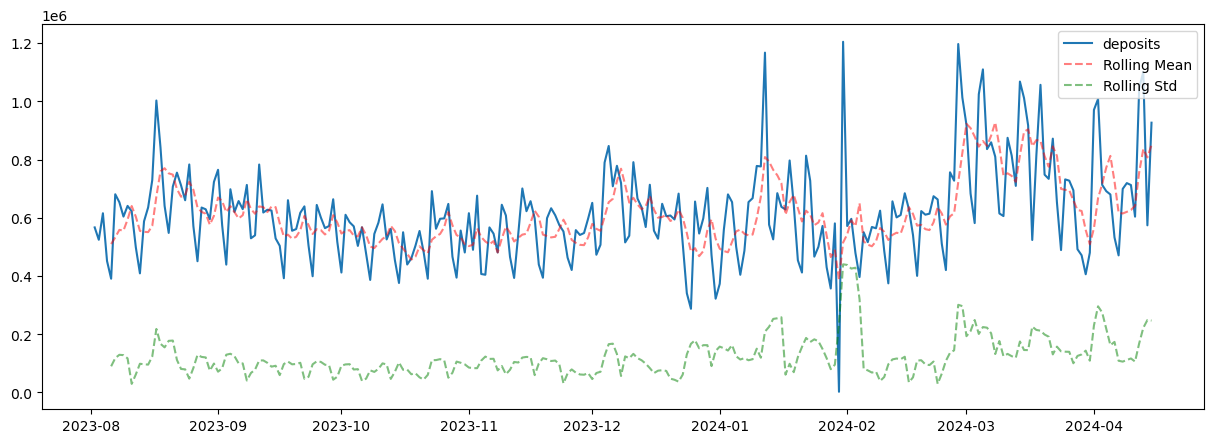

In [9]:
test_stationary(data, 'deposits')

## Data Stationary using Time Shift 

Test Statistic:                 -6.91
p-value:                         0.00
# Lags Used:                    12.00
Number of Observations Used:   244.00
dtype: float64
---------------------------------------
criticality 1% : -3.457437824930831
criticality 5% : -2.873459364726563
criticality 10% : -2.573122099570008


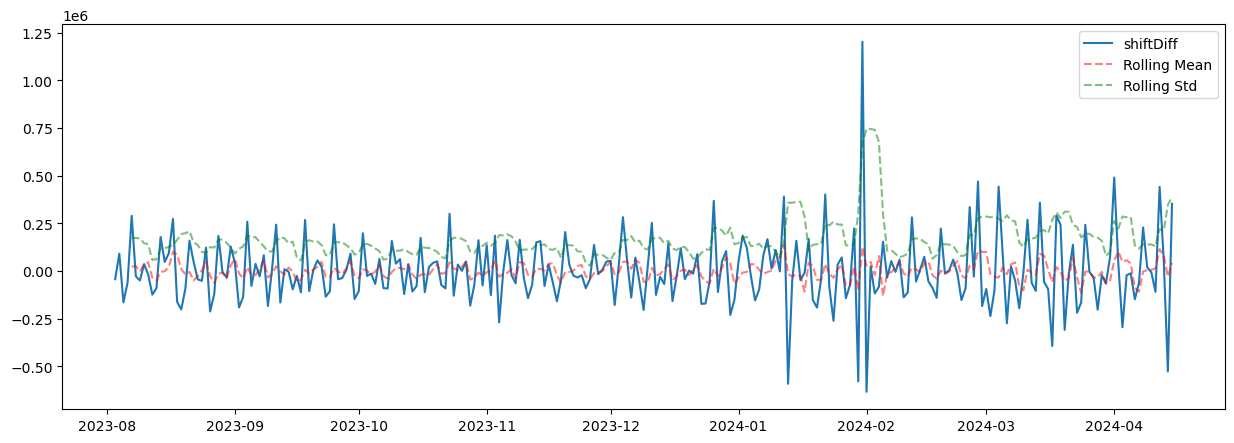

In [10]:
shif_df =  data[['deposits']]
shif_df = shif_df.dropna()
shif_df['shift'] = shif_df.deposits.shift()
shif_df['shiftDiff'] = shif_df['deposits'] - shif_df['shift']

test_stationary(shif_df.dropna(), 'shiftDiff')

# Data Stationary using Log

Test Statistic:                 -3.74
p-value:                         0.00
# Lags Used:                     6.00
Number of Observations Used:   251.00
dtype: float64
---------------------------------------
criticality 1% : -3.4566744514553016
criticality 5% : -2.8731248767783426
criticality 10% : -2.5729436702592023


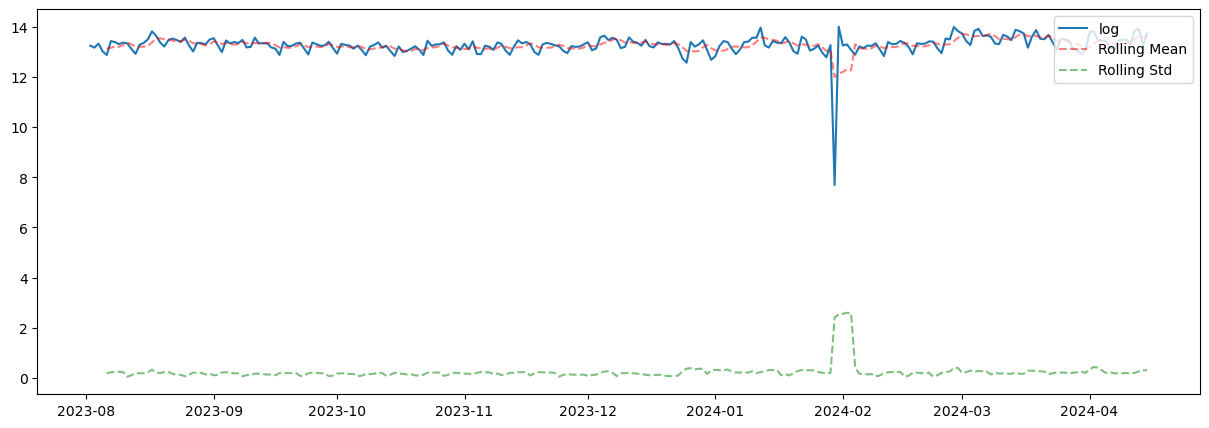

In [11]:
log_df = data[['deposits']]
log_df['log'] = np.log(log_df['deposits'])
log_df.head()

test_stationary(log_df, 'log')

# Data Stationary using sqrt

Test Statistic:                 -2.34
p-value:                         0.16
# Lags Used:                    15.00
Number of Observations Used:   242.00
dtype: float64
---------------------------------------
criticality 1% : -3.457664132155201
criticality 5% : -2.8735585105960224
criticality 10% : -2.5731749894132916


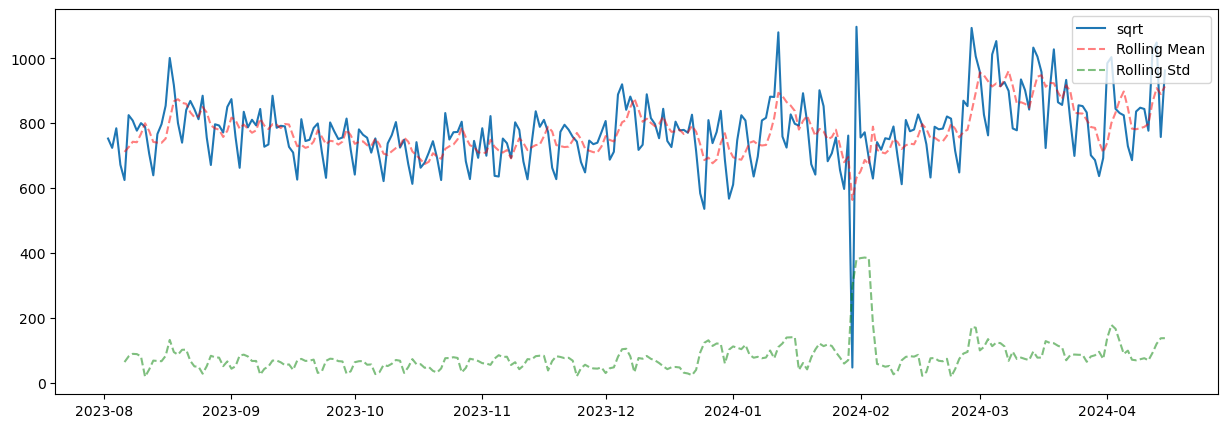

In [12]:
sqrt_df = data[['deposits']]
sqrt_df['sqrt'] = np.sqrt(data['deposits'])

test_stationary(sqrt_df, 'sqrt')

# Training and Test Set

In [13]:
data_ = data[['deposits']].copy(deep=True)
data_['Diff'] = data_['deposits'].diff()
data_['Diff12'] = data_['deposits'].diff(12)

In [14]:
# Calculate the index for splitting (70% for training, 30% for testing)
split_index = int(len(data_) * 0.7)

# Split the DataFrame into training and testing sets
train = data_.iloc[:split_index]
test = data_.iloc[split_index:]

# Print the lengths of training and testing sets
print("Training set length:", len(train))
print("Testing set length:", len(test))

Training set length: 180
Testing set length: 78


In [33]:
modelo_auto = auto_arima(data_['deposits'], 
                         start_p=0, d=1, start_q=0, 
                         max_p=4, max_d=2, max_q=4, startP=0,
                        D=1, start_Q=0, max_P=2, max_D=1,
                        error_action='warn', trace=True,
                        supress_warnings=True, stepwise=True,
                        random_state=20, n_fits=50)
print(modelo_auto)
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6959.968, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6931.403, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6877.292, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6957.985, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6872.554, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6871.333, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6909.215, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6872.465, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6870.672, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6869.858, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6869.125, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6871.987, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6864.712, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : 

In [23]:
model = SARIMAX(train['deposits'], order=(2, 1, 1), seasonal_order=(1,1,3,7))
model_fit = model.fit()

start = test.index[0].strftime('%Y-%m-%d')
end = test.index[0].strftime('%Y-%m-%d')

sarimax_prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
data_['SARIMAX'] = sarimax_prediction 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24219D+01    |proj g|=  2.31915D-01

At iterate    5    f=  1.23606D+01    |proj g|=  3.77247D-02

At iterate   10    f=  1.23574D+01    |proj g|=  5.59218D-04

At iterate   15    f=  1.23574D+01    |proj g|=  8.43336D-04

At iterate   20    f=  1.23572D+01    |proj g|=  6.89464D-03

At iterate   25    f=  1.23571D+01    |proj g|=  1.23766D-03

At iterate   30    f=  1.23570D+01    |proj g|=  4.03812D-03

At iterate   35    f=  1.23569D+01    |proj g|=  9.79921D-04

At iterate   40    f=  1.23569D+01    |proj g|=  1.35351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

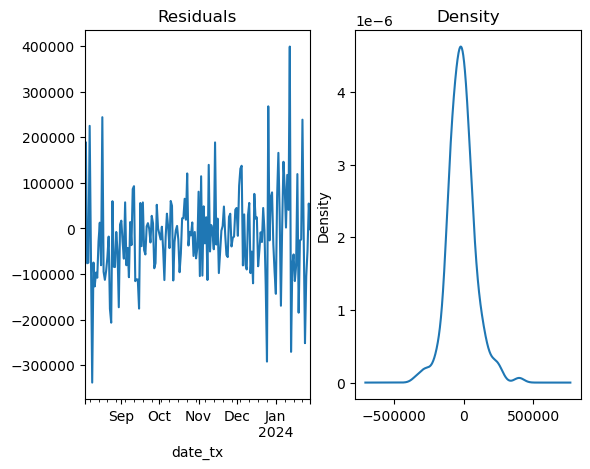

In [30]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde',ax=ax[1])
plt.show()

In [25]:
model_ = ARIMA(train['deposits'], order=(5, 1, 3))
model_fit_ = model_.fit()

start = test.index[0].strftime('%Y-%m-%d')
end = test.index[0].strftime('%Y-%m-%d')

arima_prediction = model_fit_.predict(start=test.index[0], end=test.index[-1])
data_['ARIMA'] = arima_prediction 

In [32]:
import statsmodels.api as sm

acf, ci_ = sm.tsa.acf(train['deposits'], alpha=0.05)
pacf, ci = sm.tsa.pacf(train['deposits'], alpha=0.05)

print(acf, ci_)

[ 1.          0.37116227  0.01353777  0.07291377  0.08400537 -0.04587481
  0.17679117  0.48248978  0.14300686 -0.1484525  -0.0532391  -0.03313718
 -0.15902189  0.04665703  0.33392229  0.03739997 -0.22534082 -0.14051335
 -0.13595143 -0.14720508  0.05394593  0.31149231  0.04633275] [[ 1.          1.        ]
 [ 0.22507518  0.51724936]
 [-0.1514516   0.17852714]
 [-0.0920993   0.23792685]
 [-0.08169385  0.2497046 ]
 [-0.21248046  0.12073085]
 [ 0.00991616  0.34366618]
 [ 0.31166435  0.65331521]
 [-0.05477521  0.34078893]
 [-0.34842913  0.05152413]
 [-0.25555396  0.14907577]
 [-0.23575081  0.16947645]
 [-0.36175115  0.04370737]
 [-0.15871706  0.25203111]
 [ 0.12832212  0.53952247]
 [-0.17946576  0.25426571]
 [-0.44234416 -0.00833748]
 [-0.36245438  0.08142768]
 [-0.35978296  0.0878801 ]
 [-0.37279198  0.07838183]
 [-0.17368175  0.28157361]
 [ 0.08359195  0.53939268]
 [-0.19047939  0.28314488]]


<Axes: xlabel='date_tx'>

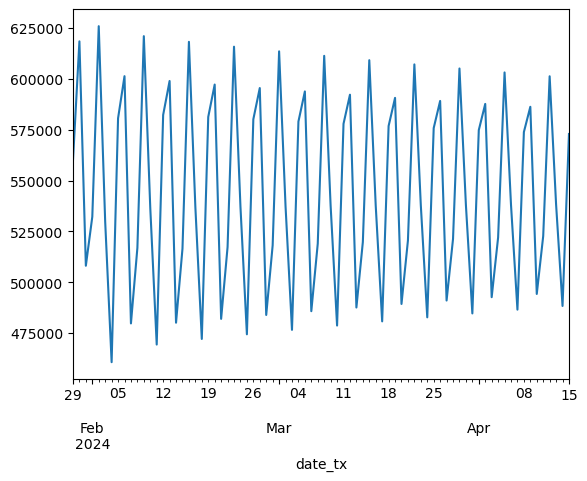

In [26]:
data_['ARIMA'].dropna().plot()

<Axes: xlabel='date_tx'>

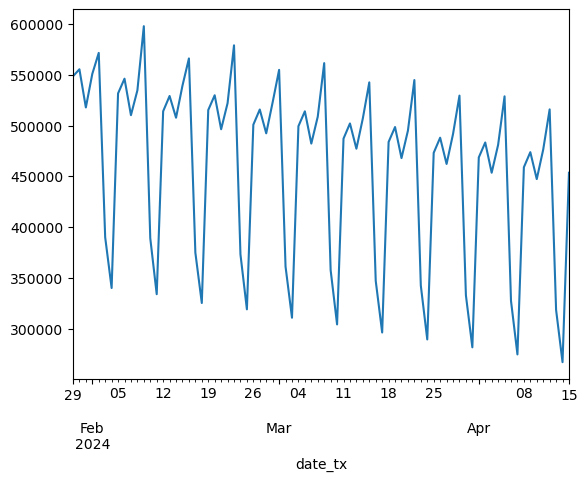

In [27]:
data_['SARIMAX'].dropna().plot()

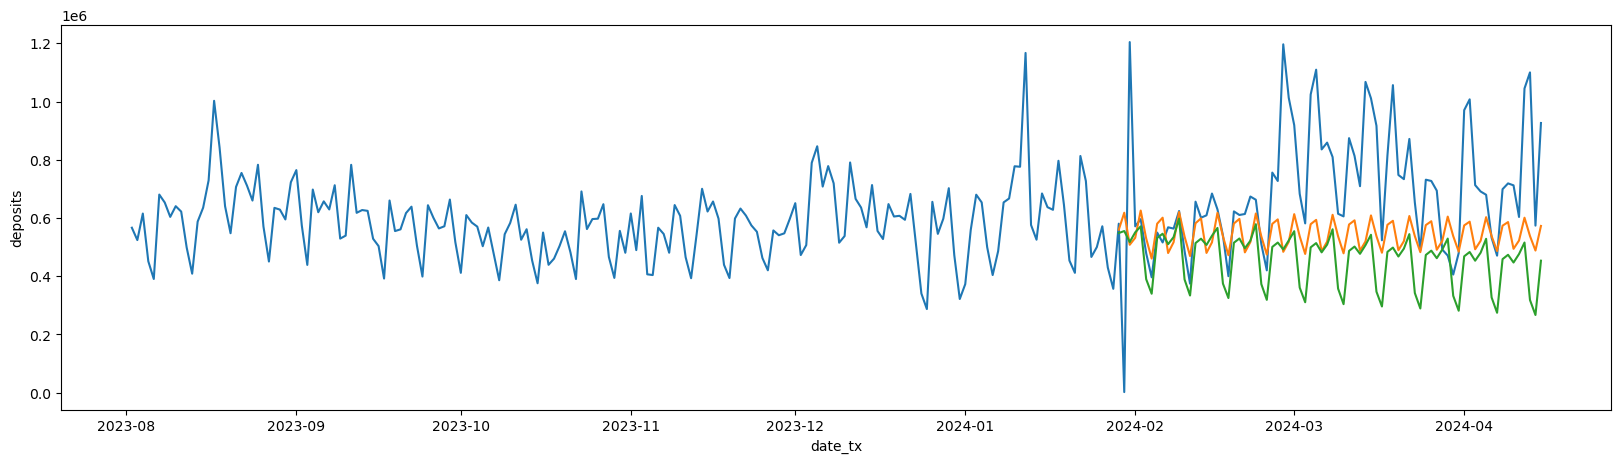

In [34]:
plt.figure(figsize=(20, 5))  # Set the figure size

sns.lineplot(data=data_, x=data_.index, y='deposits')
sns.lineplot(data=data_, x=data_.index, y='ARIMA')
sns.lineplot(data=data_, x=data_.index, y='SARIMAX')

plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['deposits'], sarimax_prediction))

312944.64977749233